# RVAA - RealVsAiArt-based model
This notebook contains the code of our attempts at training a model on the RVAA dataset. 

The RVAA dataset contains around 2k images, which can either be real or AI-generated. However, unlike CIFAKE, the images are completely heterogenous: they have different resolution, different aspect-ratios and even different RGB formats. In addition, some of the images tagged as AI-generated are only "partially" so: in some cases, an image from a diffusion model will be shown side-by-side with a real image, or text will be present all over the image.

This can pose quite the challenge for our model. Nevertheless, the final results are quite promising.

In [13]:
import torch
from torchvision.models import resnet50
import model_utils
import plotter
import data_utils
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
import importlib
import pandas as pd
import torchvision.transforms as transforms
import xai

seed=42
model_utils.fix_random(seed)

TRAINING_MODE=True
plotter.set_display_mode(True)

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # fixes PIL warning

In [14]:
dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt")
df_stats = data_utils.get_dataset_stats(dataset)
pd.DataFrame.from_dict(df_stats, orient='index')

# size of image to resize
IMG_SIZE = 224
DATASET_NAME = 'RVAA'

In [15]:
transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize(IMG_SIZE),                  # Resize the shorter side to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square),  # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),      # Ensure the final image is exactly IMG_SIZExIMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform)

LEARNING_RATE = 3e-4
EPOCHS = 20
BATCH_SIZE = 32

# WARNING: IF YOU REBUILD THE DATALOADER, THE RESULT WILL DIFFER. RESTART THE KERNEL AND TRAIN AGAIN TO HAVE THE SAME RESULTS.
train_dataset, val_dataset, test_dataset = data_utils.train_test_split((0.7, 0.15), dataset=dataset, isRandom=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

loss_fn = nn.BCEWithLogitsLoss()
device = model_utils.get_device()
print(f"using {device} device")

dataloaders = (train_dataloader, val_dataloader)

using cuda device


In [16]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=2)
ft_resnet50.to(device)

optimizer = torch.optim.Adam(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50"

In [17]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              ft_resnet50, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 53.8%, Avg loss: 0.667461
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 72.4%, Avg loss: 0.644659
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 55.9%, Avg loss: 0.625704
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 66.9%, Avg loss: 0.593664
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 73.8%, Avg loss: 0.575053
New best model found! (based on lowest loss)
...and saved.


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 73.1%, Avg loss: 0.568446
New best model found! (based on lowest loss)
...and saved.


Epoch 7/20
-------------------------------
Validatio

Test Error:
Accuracy: 77.4%, Avg loss: 0.483911
Confusion matrix report, tp: 44, fp: 18, fn: 15, tn:69
True


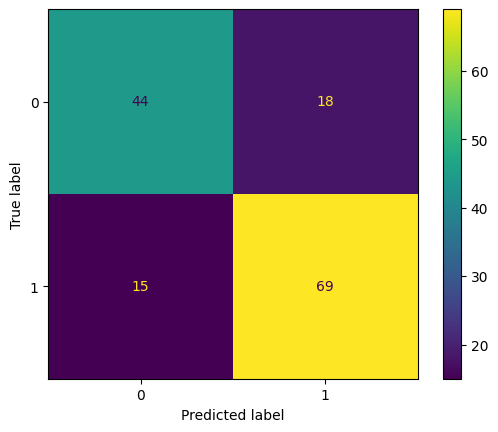

Precision: 0.71, Recall: 0.75, F1-Score: 0.73


(0.4839110314846039, tensor(0.7740, device='cuda:0'))

In [18]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

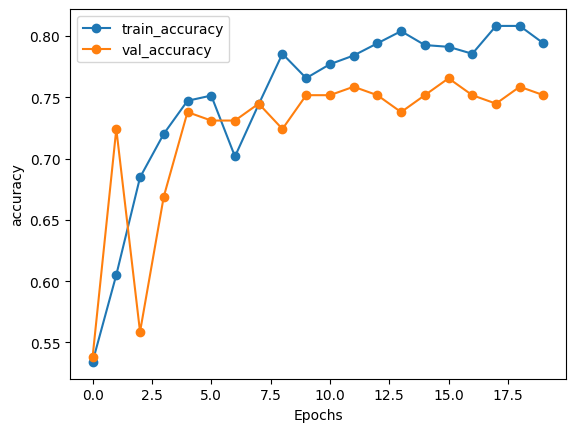

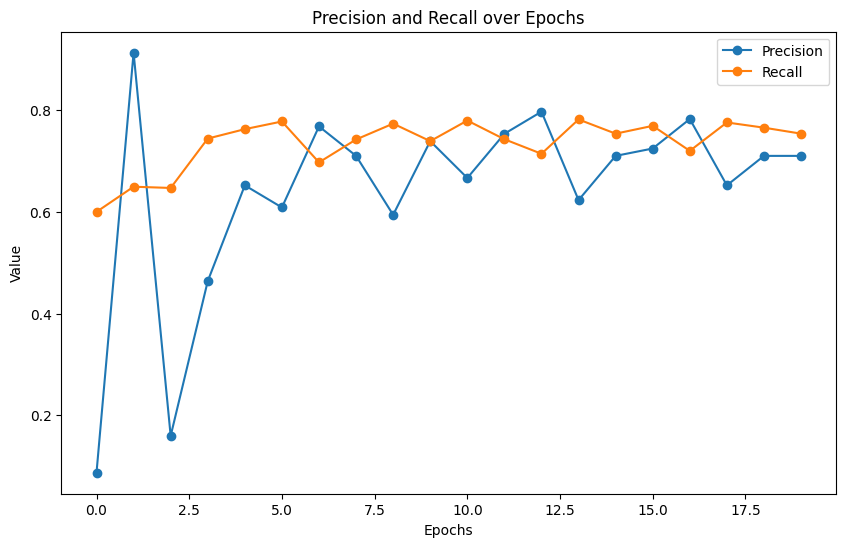

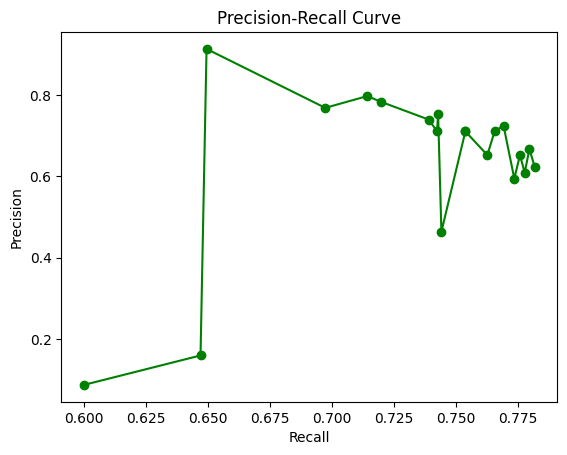

In [19]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

Step2 FT

In [20]:
for param in ft_resnet50.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_beefy"

In [21]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 49.7%, Avg loss: 2.754002
New best model found! (based on lowest loss)


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 69.7%, Avg loss: 1.250394
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 69.7%, Avg loss: 1.111995
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 73.1%, Avg loss: 1.454784


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 62.1%, Avg loss: 1.320633


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 66.9%, Avg loss: 1.074055
New best model found! (based on lowest loss)
...and saved.


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 77.2%, Avg loss: 0.726995
New best model found! (based on lowest loss)
...and saved.


Epoch 8/20
---------------

Test Error:
Accuracy: 83.6%, Avg loss: 0.556316
Confusion matrix report, tp: 52, fp: 10, fn: 14, tn:70
True


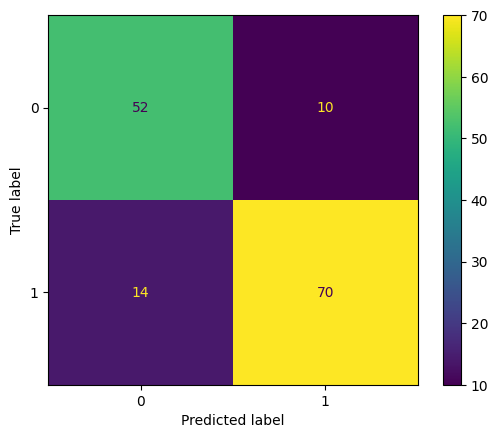

Precision: 0.84, Recall: 0.79, F1-Score: 0.81


(0.5563159227371216, tensor(0.8356, device='cuda:0'))

In [22]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

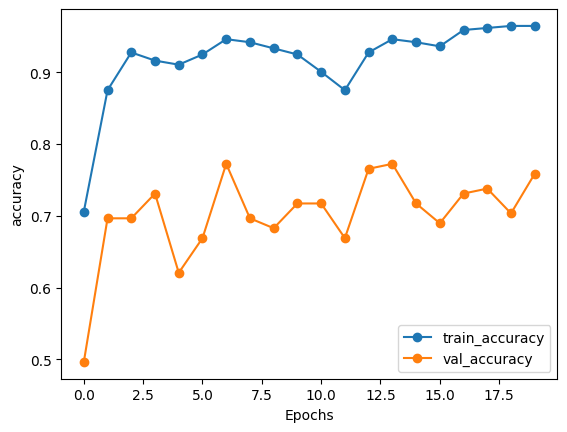

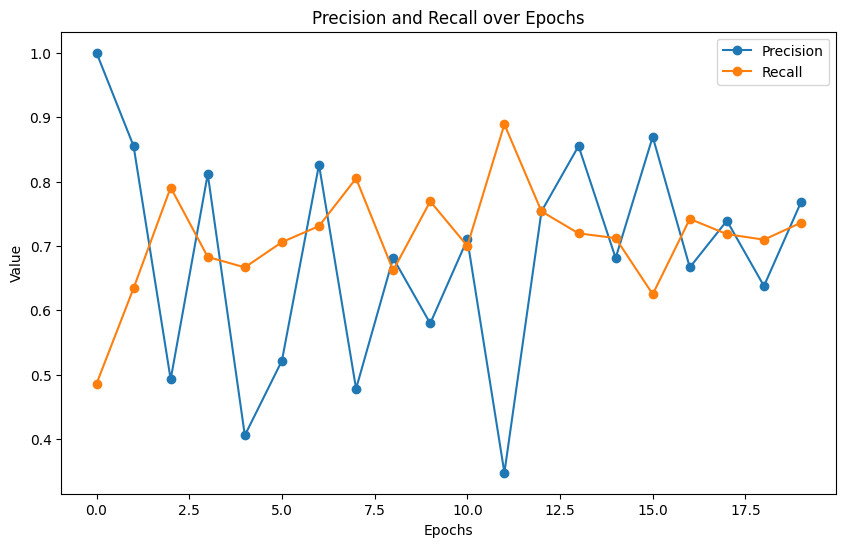

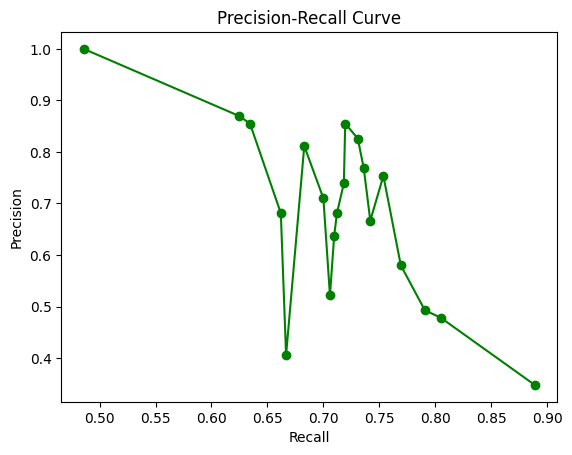

In [23]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

GradCAM Test

100%|██████████| 64/64 [00:11<00:00,  5.71it/s]


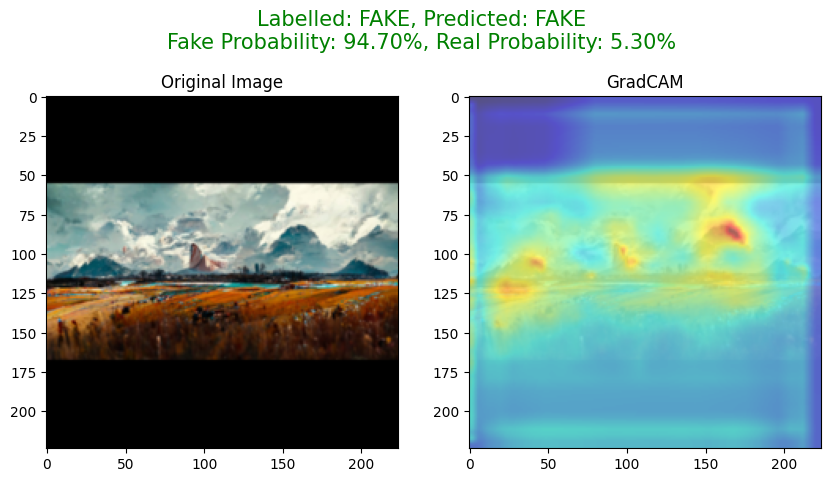

In [24]:
importlib.reload(xai)

xai.set_device(device)
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 16)

100%|██████████| 64/64 [00:06<00:00,  9.69it/s]


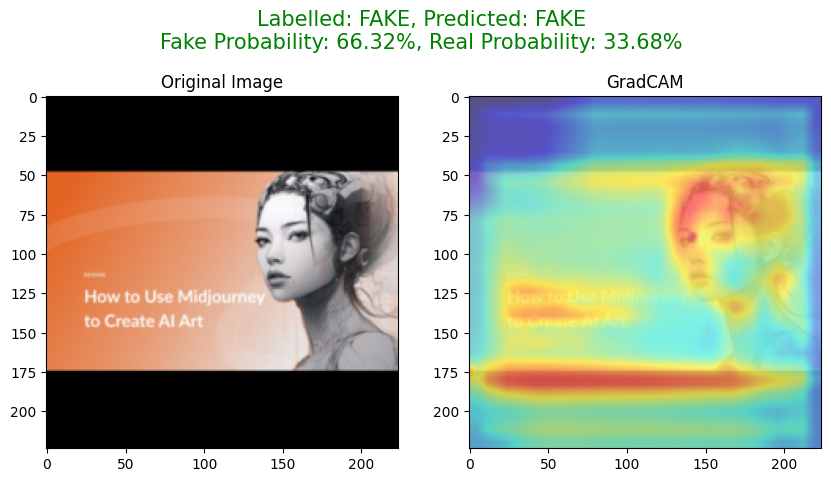

In [ ]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer3, ft_resnet50.layer4],
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 2)

100%|██████████| 128/128 [02:11<00:00,  1.03s/it]


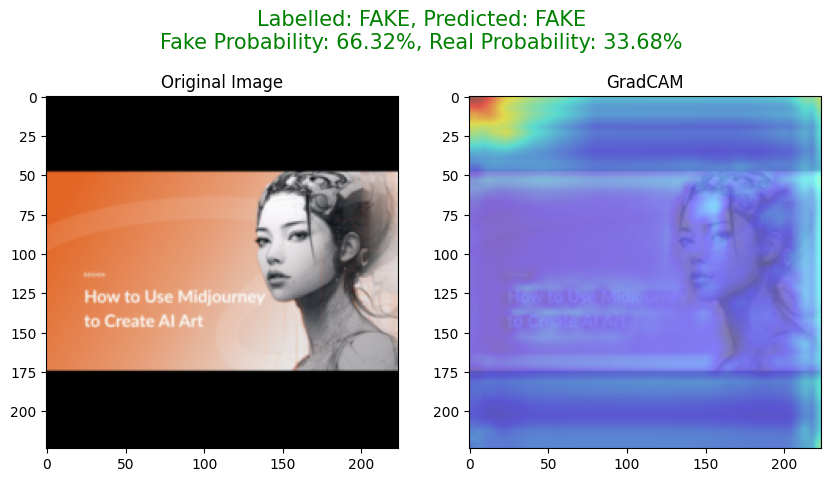

In [26]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 2,
                                mapper="sc")

100%|██████████| 128/128 [00:07<00:00, 16.17it/s]


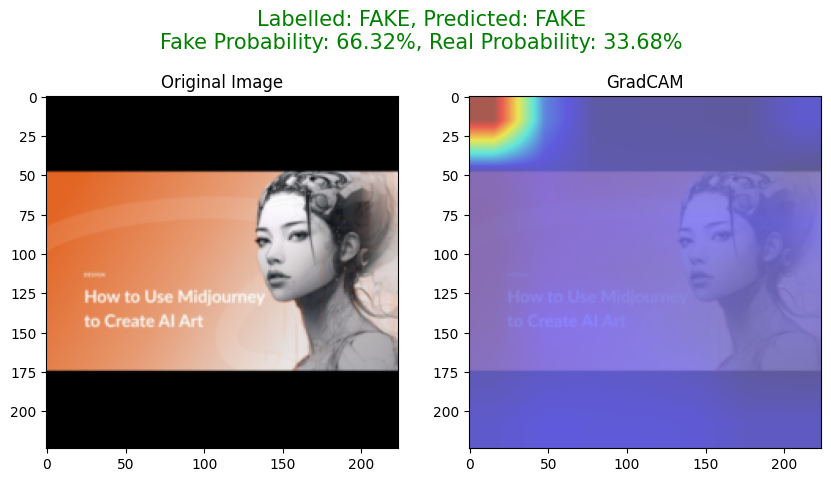

In [27]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50,
                                ft_resnet50.layer4,
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 2,
                                mapper="sc")

LIME experiment

  0%|          | 0/1000 [00:00<?, ?it/s]

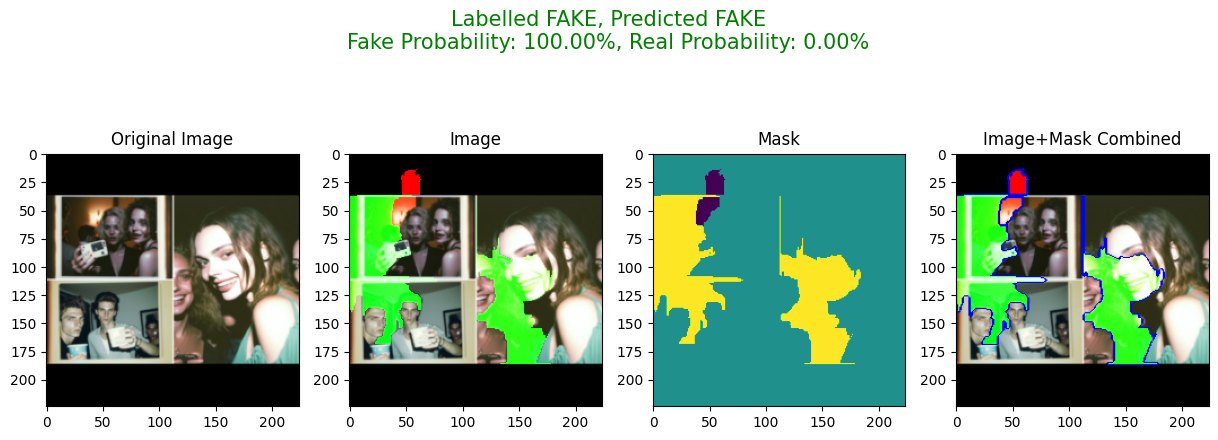

In [28]:
importlib.reload(xai)

xai.explain_lime_single_image(test_dataloader, ft_resnet50,
                              model_name = model_name, dataset_name = DATASET_NAME,
                              index = 3)

### GradCam batch visualization

In [29]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=2)
ft_resnet50.to(device)
ft_resnet50.load_state_dict(torch.load("checkpoints/best_RVAA_FTRes50_beefy.pth"))
model_name = "ModResNet50_beefy"

In [30]:
xai.explain_gradcam_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4], model_name, DATASET_NAME)

100%|██████████| 64/64 [00:06<00:00,  9.32it/s]


Visualized batch #1!


### Lime batch visualization

In [31]:
xai.explain_lime_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50,
                        model_name=model_name, dataset_name=DATASET_NAME,
                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Visualized batch #1!


### Data Augmentation Experiment

In [32]:
augmented_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.RandomResizedCrop(size=(224, 224)),  # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(20),  # Randomly rotate the image by up to 20 degrees
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


In [33]:
from torch.utils.data import DataLoader, Subset, ConcatDataset
import numpy as np
from torchvision import transforms

original_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform)

# we are doing the same thing as the train_test_split function
train_size = int(0.7 * len(original_dataset))
val_size = int(0.15 * len(original_dataset))
test_size = len(original_dataset) - train_size - val_size

generator = torch.Generator()
generator.manual_seed(seed)
train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(original_dataset)),
    [train_size, val_size, test_size],
    generator=generator
)

train_dataset = Subset(original_dataset, train_indices)
val_dataset = Subset(original_dataset, val_indices)
test_dataset = Subset(original_dataset, test_indices)

augmented_size = int(1.0 * len(train_dataset))
augmented_indices = np.random.choice(len(train_dataset), augmented_size, replace=False)

augmented_train_dataset = Subset(data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=augmented_transform),
                                 [train_indices[i] for i in augmented_indices])

combined_train_dataset = ConcatDataset([train_dataset, augmented_train_dataset])

train_dataloader = DataLoader(combined_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = (train_dataloader, val_dataloader)


In [34]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=2)
ft_resnet50.to(device)

optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_experiment"


In [35]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Training loss: 0.634277, train accuracy: 60.23%  [ 1280/ 1358]
Validation Error:
Accuracy: 54.5%, Avg loss: 0.653256
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Training loss: 0.598437, train accuracy: 62.89%  [ 1280/ 1358]
Validation Error:
Accuracy: 68.3%, Avg loss: 0.611471
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Training loss: 0.553370, train accuracy: 72.34%  [ 1280/ 1358]
Validation Error:
Accuracy: 72.4%, Avg loss: 0.581913
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Training loss: 0.543464, train accuracy: 73.91%  [ 1280/ 1358]
Validation Error:
Accuracy: 73.8%, Avg loss: 0.565283
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Training loss: 0.597997, train accuracy: 74.77%  [ 1280/ 1358]
Validation

Test Error:
Accuracy: 78.8%, Avg loss: 0.456213
Confusion matrix report, tp: 45, fp: 17, fn: 14, tn:70
True


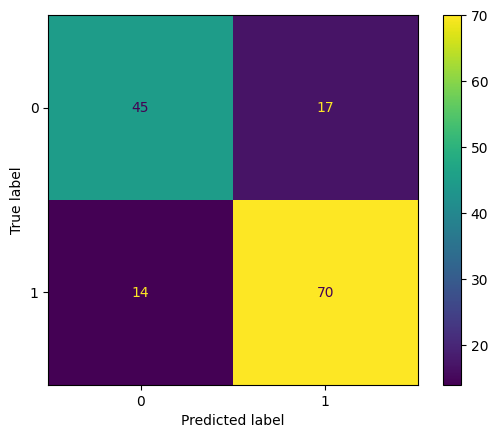

Precision: 0.73, Recall: 0.76, F1-Score: 0.74


(0.4562133848667145, tensor(0.7877, device='cuda:0'))

In [36]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

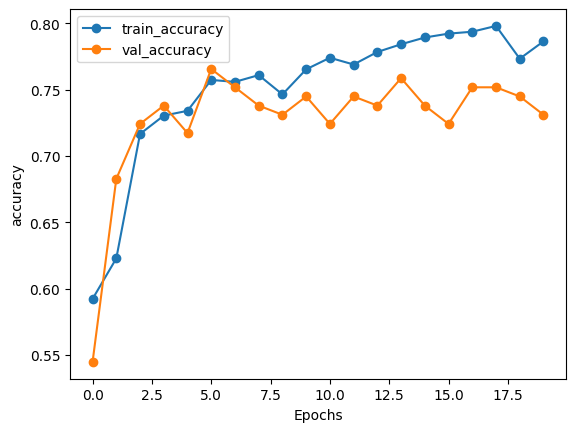

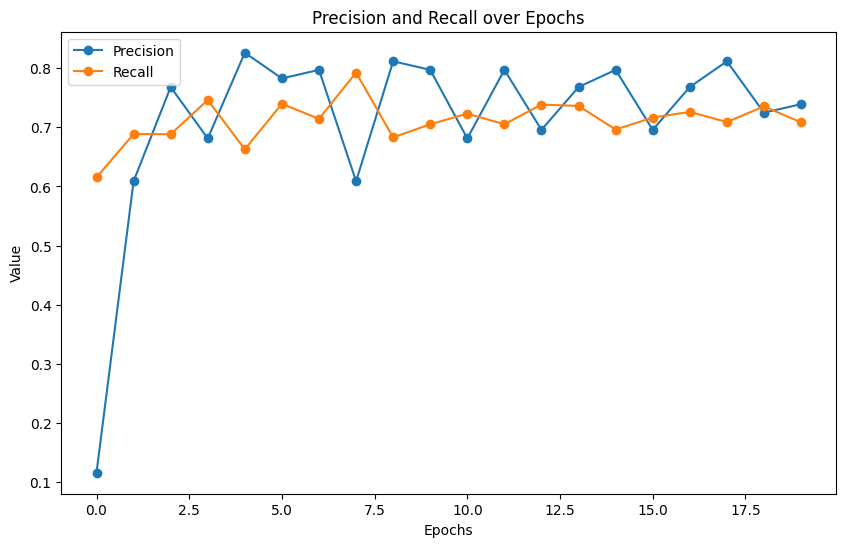

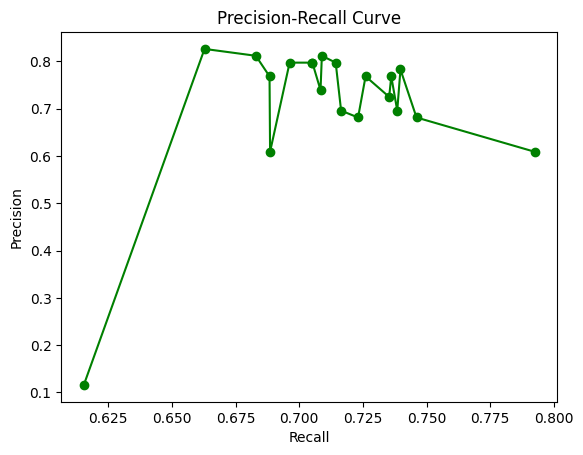

In [37]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

In [38]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_experiment_beefy"

In [39]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Training loss: 0.530997, train accuracy: 72.19%  [ 1280/ 1358]
Validation Error:
Accuracy: 73.8%, Avg loss: 2.327377
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Training loss: 0.287504, train accuracy: 84.38%  [ 1280/ 1358]
Validation Error:
Accuracy: 69.7%, Avg loss: 0.948086
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Training loss: 0.362618, train accuracy: 89.69%  [ 1280/ 1358]
Validation Error:
Accuracy: 74.5%, Avg loss: 0.701904
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Training loss: 0.214888, train accuracy: 90.86%  [ 1280/ 1358]
Validation Error:
Accuracy: 77.9%, Avg loss: 0.731859


Epoch 5/20
-------------------------------
Training loss: 0.292151, train accuracy: 91.25%  [ 1280/ 1358]
Validation Error:
Accuracy: 69.0%, Avg loss: 1.378090


Epoch 6/20
--

Test Error:
Accuracy: 84.2%, Avg loss: 0.403639
Confusion matrix report, tp: 56, fp: 6, fn: 17, tn:67
True


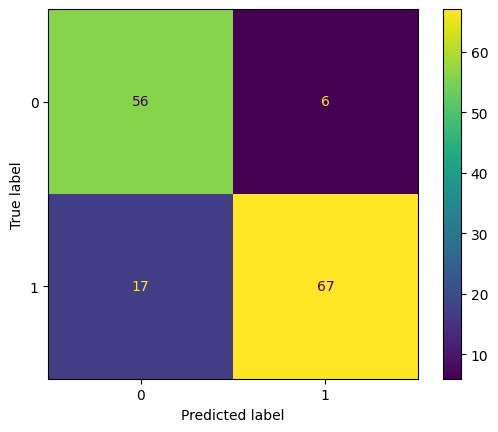

Precision: 0.90, Recall: 0.77, F1-Score: 0.83


(0.40363851487636565, tensor(0.8425, device='cuda:0'))

In [40]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

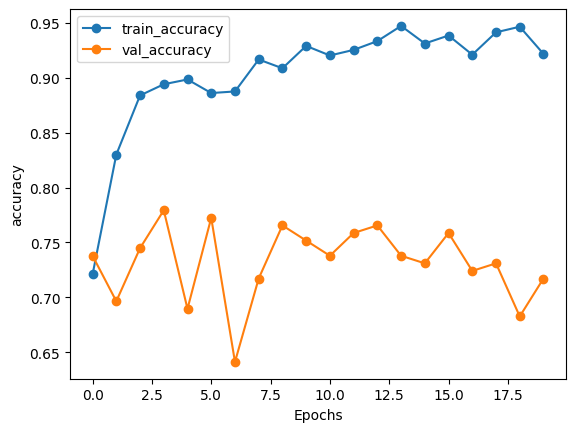

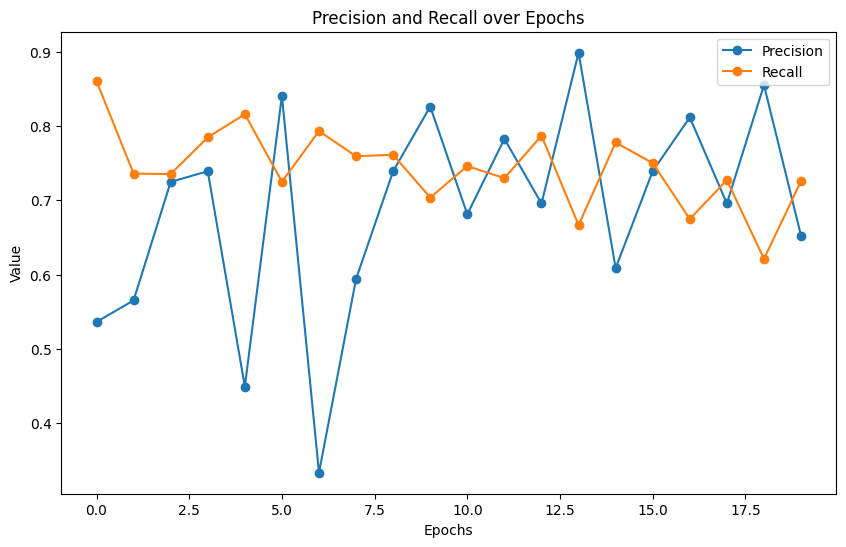

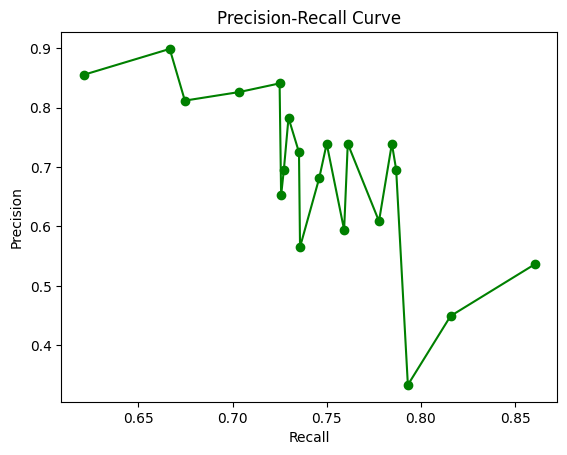

In [41]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)